# Comparison Avatar with Original : WBCD - R

In this notebook, we compare tha avatar with original data using the WBCD dataset. 
We use the avatarized dataset with the parameter k = 20. 

We perform 2 analyses : 
- 1 - projection comparison 
- 2 - Protection level : metrics (local cloaking and hidden rate).

a third analysis (F-score and AUC comparison) was perform with a python kernel in the noteboook `messageA_WBCD_python.ipynb` 

## Library import

In [1]:
library(reticulate)
library(tidyverse)
library(FactoMineR)
library(plot3D)
library(survival)
library(survminer)
library(mice)
library(reshape2)

library(VIM)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Loading required package: ggpubr

Attaching package: ‘mice’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    cbind, rbind


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: colorspace
Loading required package: grid
VIM is ready to use.

Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

Attaching package: ‘VIM’

The following object is masked from ‘package:datasets’:

    sle

In [2]:
colors = read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) = colors$type
colors

,type,color
avatar,avatar,#67C6A7
original,original,#f5f5f5
k_small,k_small,#c6eade
k_high,k_high,#407c68
benign,benign,#6786c6
malignant,malignant,#e19252
wbcd,wbcd,#a767c6
aids,aids,#c6a767


In [4]:
# import specific function to compute metrics 
py_run_string("import sys")
py_run_string("sys.path.append('../../lsg')")

py_run_string("from lsg.security_metrics.security_metrics_class import Security_metrics ")
py_run_string("from lsg.dimension.projection import Projection")
py_run_string("from lsg.security_metrics.record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from lsg.security_metrics.local_cloaking import local_cloaking")


In [5]:
data <- read.csv("../../datasets/WBCD/breast_cancer_wisconsin.csv", sep = ",", na.strings = c("NA", 
    "", NA))
data <- data[, -1]
avatar <- read.csv("../../datasets/WBCD/breast_cancer_wisconsin_avatarized_k20.csv", 
    sep = ",", na.strings = c("NA", "", NA))

avatar$Class = as_factor(avatar$Class)

data$Class = as_factor(data$Class)

In [6]:
file_results = '../../figure/'

## Graph in 2D


We are here printing the mutlidimensionnal projection on the two first component of the FAMD (Factorial analysis of mixed data).

Individuals are colored by data sources : ORIGINAL or AVATARS.

In [7]:
data_tot <- rbind(data, avatar)


In [8]:
# Perform FAMD with avatar as supplemental indivudals
famd <- FAMD(data_tot, ncp = 5, graph = FALSE, ind.sup = (nrow(data_tot)/2 +1):nrow(data_tot))
res_ind <- as.data.frame(famd$ind$coord)
res_ind_sup <- as.data.frame(famd$ind.sup$coord)

In [9]:
# bind and label two df
res_ind_2D = res_ind[,1:2]
res_ind_2D['type'] = 'Originals'
res_ind_sup['type'] = 'Avatars'
res_ind_2D = rbind(res_ind_2D, res_ind_sup[, c('Dim.1', 'Dim.2', 'type')])

set.seed(43)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows, ]



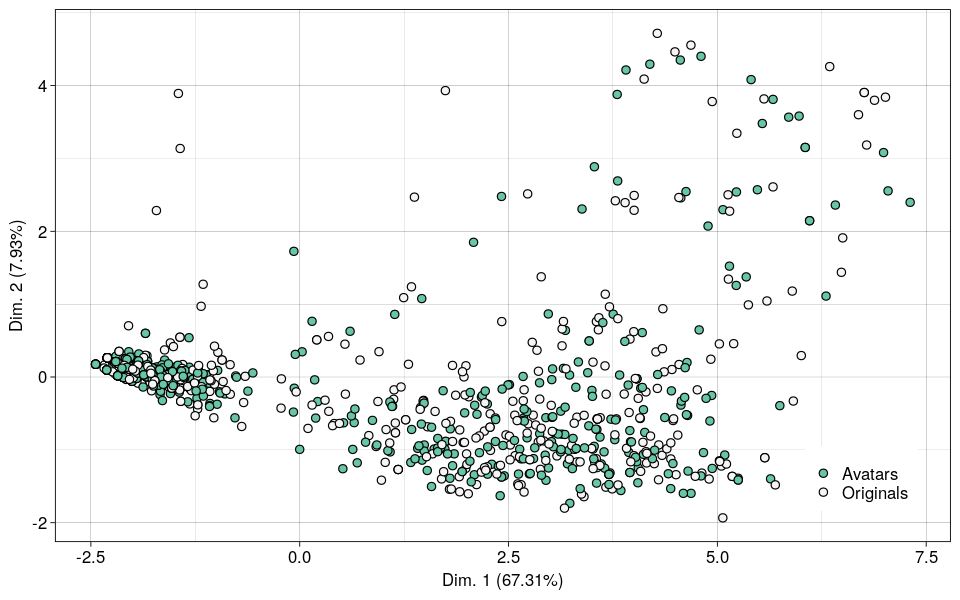

In [10]:
save = FALSE

options(repr.plot.width = 8, repr.plot.height = 5)
if (save) {
    tiff(paste0(file_results, "WBCD_pca2D.tiff"), res = 600, width = 14, height = 8, units = "cm")
}


ggplot(res_ind_2D, aes(x=Dim.1, y=Dim.2, fill=type)) +
    # add points
    geom_point(size=2, shape=21, alpha= 1) +
    # fill according data source
    aes(fill = factor(type)) +
    scale_fill_manual(values=c(colors["avatar","color"], colors["original","color"])) +
        # add axis label with exlplained variability
    xlab(paste0("Dim. 1 (", round(famd$eig[1,2], 2) ,"%)")) +
    ylab(paste0("Dim. 2 (", round(famd$eig[2,2], 2) ,"%)")) +
    # theme and figure details
    theme_linedraw() +
    theme(legend.position = c(0.9, 0.12), 
          legend.title = element_blank(),
          legend.key.size = unit(0.4, "cm"),
         legend.text = element_text(size = 10, color = "black", family="Helvetica"),
         axis.text = element_text(size =  10, color="black", family="Helvetica"),
         axis.title = element_text(size = 10, color = "black", family="Helvetica"))

if (save) {
    dev.off()
}


## Protection level : metrics   

This section provide the computation of protection metrics (local cloaking and hidden rate).



### Local cloaking distribution figure

We first compute metrics, which need the security metrics specifique function,   
Then we display the distribution of the local cloaking

In [11]:
metrics = py$Security_metrics()
metrics$fit(data, avatar, nf= 5L)

In [12]:
df_local_cloaking <- data.frame(metrics$local_cloaking["hit_counts"])


Warning message:
“Removed 201 rows containing non-finite values (stat_bin).”Warning message:
“Removed 201 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

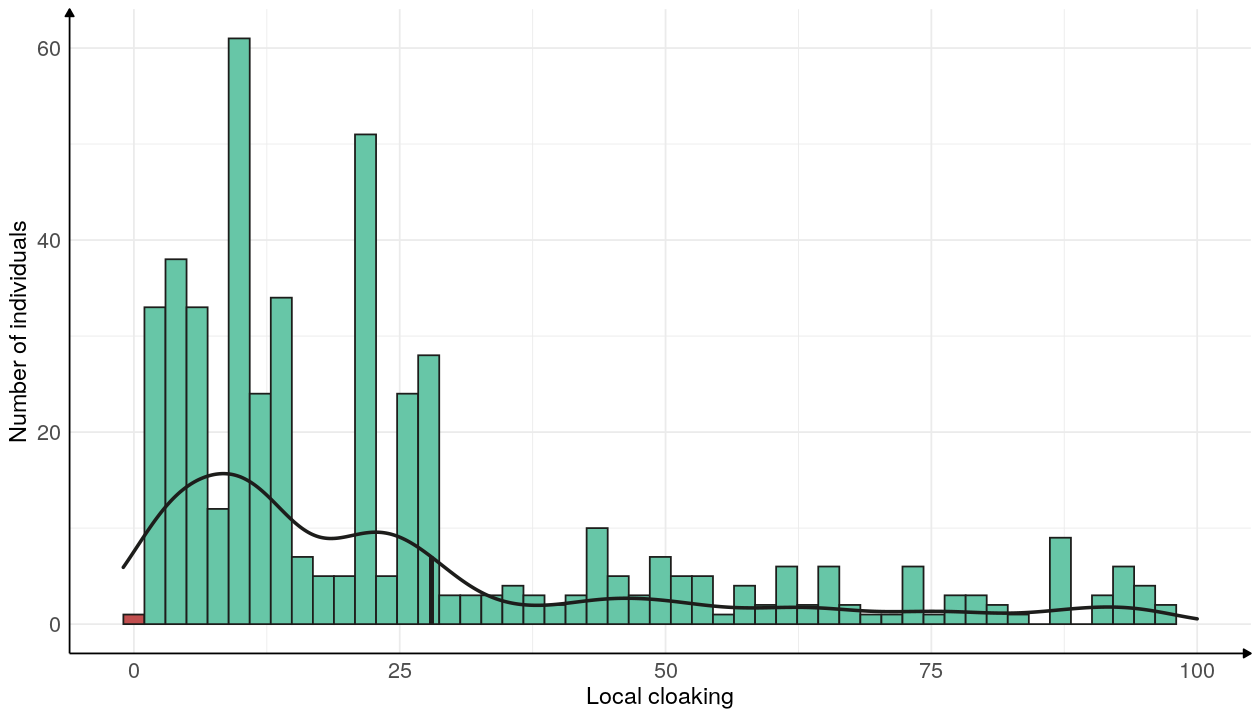

In [13]:
save = FALSE

options(repr.plot.width = 10.5, repr.plot.height = 6)

color_vector =  c(rep("#c14f4f",2), rep(colors['avatar', 'color'],50))


if (save) {tiff(paste0(file_results,"WBCD_local_cloaking.tiff"), width = 18, height = 14, units = "cm", res = 300)}
dist = ggplot(df_local_cloaking, aes(hit_counts.1)) +
    geom_histogram(bins = 52, fill = color_vector, color = "#1D1D1B") +
    geom_density(aes(y= ..count..), lwd = 1, color = "#1D1D1B") +
    xlim(c(-1,100)) +
    theme_minimal() +
    xlab("Local cloaking") +
    ylab("Number of individuals") +
   theme(axis.title = element_text(size =14, family="Helvetica"),
          axis.text = element_text(size = 13, family = "Helvetica"),
         axis.line = element_line(colour = "black",
                          size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+
    geom_segment(aes(x = median(hit_counts.1), 
                     y = 0, 
                     xend = median(hit_counts.1), 
                     yend = 7), color= '#1D1D1B', size = 1) +
    scale_color_manual(name = "statistics", values = c(median = "red"))

dist
if (save) {dev.off()}

###  Zero cloaking over 25 avatarizations


Here, we had performe 25 diffferent avatarizations with same parameters **(`k = 20, nf = 2`)**.  
We then look at the number of time, each individual generates an avatar with a local cloaking at 0.

We print it distribution,the number of individuas according the number of zero local cloaking.


In [14]:
avatar_tot = read.csv('../../datasets/WBCD/wbcd_avatarized_25time_k20_nf_2.csv')
avatar_tot["Class"] = lapply(avatar_tot["Class"], factor)
pr = py$Projection()
coord_original = pr$fit_transform(data, nf = 5L)[[1]]


In [15]:
df_local_cloaking_k2 <- data.frame(row.names = 1:nrow(data))
for (k in unique(avatar_tot$iter)){
    
    avatar <- avatar_tot[avatar_tot$iter == k,]
    
    avatar_imp <- complete(mice(avatar,m=1,maxit=50,seed=500, printFlag = FALSE),1)
    avatar$cd496 <- avatar_imp$cd496
    
    coord_avatar = pr$transform(avatar[,1:(ncol(avatar) - 1)])
    distances = py$record_to_avatar_distance(coord_original, coord_avatar)
    
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k2[paste0("local_cloaking_", k, "_", 15)] <- local_cloaking$hit_counts[,1]
}

   

Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning message:
“Number of logged events: 1”Warning me

In [16]:
df_localCloaking_plot = df_local_cloaking_k2[,]
# reshape and modify data
df_localCloaking_plot[df_localCloaking_plot >= 5] <- 5
df_localCloaking_plot <- df_localCloaking_plot %>% mutate_if(is.character,as.factor)

df_localCloaking_plot = data.frame(df_localCloaking_plot)
rownames(df_localCloaking_plot) <- NULL
df_localCloaking_plot['names'] = as.numeric(rownames(df_localCloaking_plot))

# pivot widder the df
df_melt_LC <- melt(df_localCloaking_plot, c("names"))




In [17]:
# subset with only zero as local cloaking
df_melt_LC_0 = df_melt_LC[df_melt_LC['value'] == '0',]

# group by iindividuals ids
df_groupby = df_melt_LC_0  %>% 
    group_by(names, .drop = TRUE)  %>% 
    summarise(count = as.factor(n()))
df_groupby$count <- ordered(df_groupby$count, levels = c("1", "2", "3", "4", "5"))


In [18]:
# add individuals who have never had Zero as local cloaking
df_full = data.frame(names = c(1:683))
df_full = merge(x = df_full, y = df_groupby, by = "names", all = TRUE)
df_full$count = as.numeric(df_full$count)
df_full$count[is.na(df_full$count)] <- 0
df_full$count = as.factor(df_full$count)



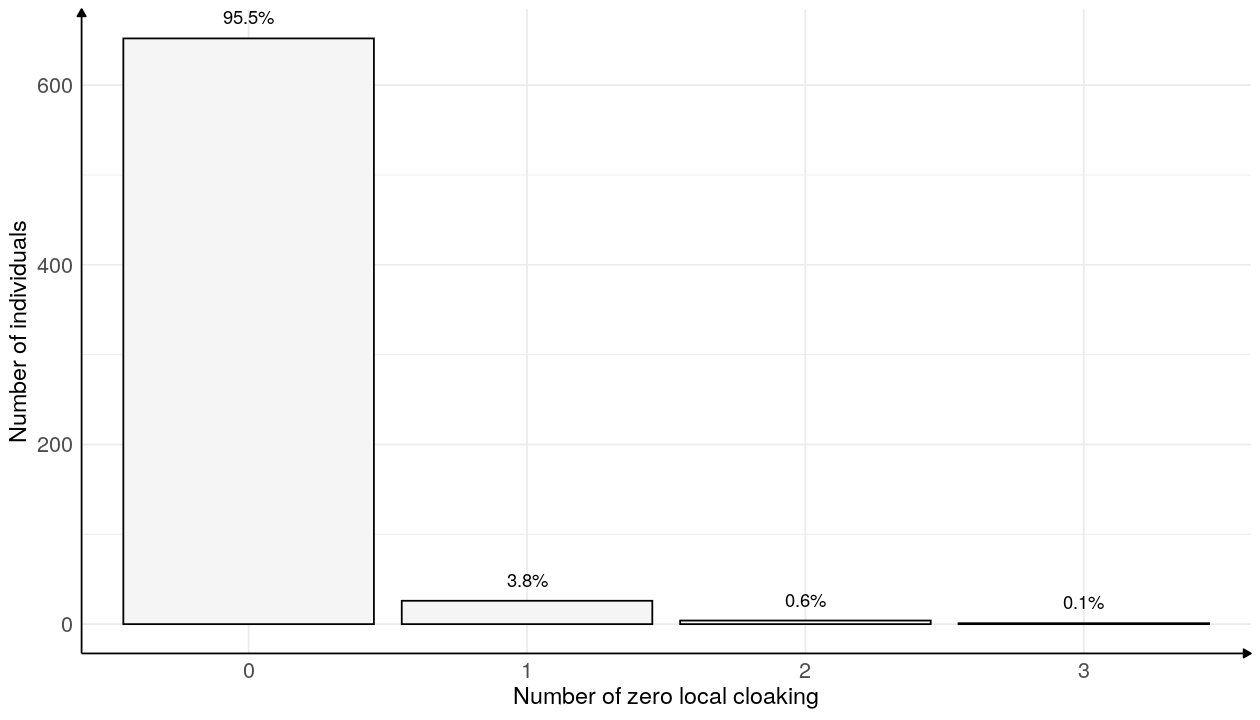

In [19]:
save = FALSE

palette2 = rep(colors["original", "color"],6)

if (save) {tiff(paste0(file_results, "wbcd_zeroCloaking_percentage.tiff"), res = 600, width = 18, height = 14, units = "cm")}


ggplot(df_full, aes(x= count, fill=count)) +
    geom_bar( colour="black", show.legend = FALSE) + 
    geom_text(
        aes(label = sprintf('%.1f%%',round( after_stat(count / sum(count) * 100), 2))),
        stat='count', vjust = -1
      )+
    ylab("Number of individuals") + 
    xlab("Number of zero local cloaking")+
    scale_fill_manual(values=palette2) + 
    theme_minimal()+
    theme(axis.title = element_text(size =14, family="Helvetica"),
          axis.text = element_text(size = 13, family = "Helvetica"),
         axis.line = element_line(colour = "black",
                          size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))
if (save) {dev.off()}